In [1]:
import requests
from config import API_KEY
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Get Data from eia API

In [2]:
eastCoast = f"http://api.eia.gov/series/?api_key={API_KEY}&series_id=PET.EMM_EPM0_PTE_R10_DPG.W"
midwest = f"http://api.eia.gov/series/?api_key={API_KEY}&series_id=PET.EMM_EPM0_PTE_R20_DPG.W"
gulfCoast = f"http://api.eia.gov/series/?api_key={API_KEY}&series_id=PET.EMM_EPM0_PTE_R30_DPG.W"
rockyMountain = f"http://api.eia.gov/series/?api_key={API_KEY}&series_id=PET.EMM_EPM0_PTE_R40_DPG.W"
westCoast = f"http://api.eia.gov/series/?api_key={API_KEY}&series_id=PET.EMM_EPM0_PTE_R50_DPG.W"

In [3]:
eastCoast_df = pd.DataFrame(requests.get(eastCoast).json()['series'][0]['data'])
midwest_df = pd.DataFrame(requests.get(midwest).json()['series'][0]['data'])
gulfCoast_df = pd.DataFrame(requests.get(gulfCoast).json()['series'][0]['data'])
rockyMountain_df = pd.DataFrame(requests.get(rockyMountain).json()['series'][0]['data'])
westCoast_df = pd.DataFrame(requests.get(westCoast).json()['series'][0]['data'])

In [4]:
eastCoast_df.rename(columns = {0:"week", 1:"price_eastCoast"}, inplace = True)
midwest_df.rename(columns = {0:"week", 1:"price_midwest"}, inplace = True)
gulfCoast_df.rename(columns = {0:"week", 1:"price_gulfCoast"}, inplace = True)
rockyMountain_df.rename(columns = {0:"week", 1:"price_rockyMountain"}, inplace = True)
westCoast_df.rename(columns = {0:"week", 1:"price_westCoast"}, inplace = True)

In [5]:
eastCoast_df['week'] = pd.to_datetime(eastCoast_df['week'])
midwest_df['week'] = pd.to_datetime(midwest_df['week'])
gulfCoast_df['week'] = pd.to_datetime(gulfCoast_df['week'])
rockyMountain_df['week'] = pd.to_datetime(rockyMountain_df['week'])
westCoast_df['week'] = pd.to_datetime(westCoast_df['week'])

In [6]:
prices_df = eastCoast_df.merge(midwest_df , on = "week", suffixes=('', ''))\
            .merge(gulfCoast_df , on = "week", suffixes=('', ''))\
            .merge(rockyMountain_df , on = "week", suffixes=('', ''))\
            .merge(westCoast_df , on = "week", suffixes=('', ''))

In [7]:
regions = ["eastCoast", "midwest", "gulfCoast", "rockyMountain", "westCoast"]
for region in regions:
    prices_df['change_' + region] = prices_df['price_' + region].diff()

In [8]:
prices_df

,week,price_eastCoast,price_midwest,price_gulfCoast,price_rockyMountain,price_westCoast,change_eastCoast,change_midwest,change_gulfCoast,change_rockyMountain,change_westCoast
0,2020-11-09,2.127,2.025,1.823,2.304,2.863,NaN,NaN,NaN,NaN,NaN
1,2020-11-02,2.149,2.026,1.862,2.320,2.869,0.022,0.001,0.039,0.016,0.006
2,2020-10-26,2.173,2.069,1.908,2.340,2.882,0.024,0.043,0.046,0.020,0.013
3,2020-10-19,2.196,2.057,1.905,2.359,2.887,0.023,-0.012,-0.003,0.019,0.005
4,2020-10-12,2.209,2.089,1.914,2.367,2.895,0.013,0.032,0.009,0.008,0.008
...,...,...,...,...,...,...,...,...,...,...,...
1436,1993-05-03,1.062,1.073,1.084,1.161,1.161,-0.007,-0.018,-0.004,0.018,-0.010
1437,1993-04-26,1.059,1.078,1.081,1.169,1.157,-0.003,0.005,-0.003,0.008,-0.004
1438,1993-04-19,1.054,1.067,1.081,1.120,1.155,-0.005,-0.011,0.000,-0.049,-0.002
1439,1993-04-12,1.047,1.077,1.071,1.118,1.154,-0.007,0.010,-0.010,-0.002,-0.001


In [9]:
prices_df.dropna(inplace =True)

<AxesSubplot:xlabel='week'>

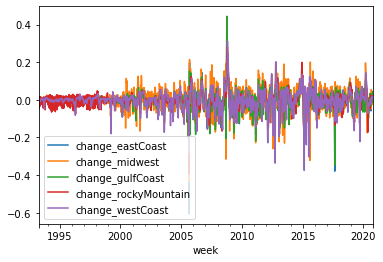

In [10]:
prices_df.plot(x = 'week', y=["change_eastCoast", "change_midwest", "change_gulfCoast", "change_rockyMountain", "change_westCoast"])

In [11]:
WTI = f"http://api.eia.gov/series/?api_key={API_KEY}&series_id=PET.RWTC.W"

In [12]:
WTI_df = pd.DataFrame(requests.get(WTI).json()['series'][0]['data'])

In [13]:
WTI_df.rename(columns = {0:"week", 1:"WTI_spotPrice"}, inplace = True)

In [14]:
WTI_df['week'] = pd.to_datetime(WTI_df['week']) + datetime.timedelta(days = 3)

In [15]:
WTI_df ['change_WTI'] = WTI_df['WTI_spotPrice'].diff()

In [16]:
#normalize WTI_change so that it is about the size of gas Price changes (100 is somewhat arbitrary)
WTI_df ['change_WTI_normalized'] = WTI_df ['change_WTI'] / 100

In [17]:
combined_df = prices_df.merge(WTI_df, on = 'week', suffixes=("",""))

## Processs the data

In [18]:
#train test split
train_size = int(0.8 * len(prices_df))
combined_df_train = combined_df.iloc[0:train_size]
combined_df_test = combined_df.iloc[train_size:]

In [19]:
combined_df_train

,week,price_eastCoast,price_midwest,price_gulfCoast,price_rockyMountain,price_westCoast,change_eastCoast,change_midwest,change_gulfCoast,change_rockyMountain,change_westCoast,WTI_spotPrice,change_WTI,change_WTI_normalized
0,2020-11-02,2.149,2.026,1.862,2.320,2.869,0.022,0.001,0.039,0.016,0.006,37.32,-0.39,-0.0039
1,2020-10-26,2.173,2.069,1.908,2.340,2.882,0.024,0.043,0.046,0.020,0.013,40.43,3.11,0.0311
2,2020-10-19,2.196,2.057,1.905,2.359,2.887,0.023,-0.012,-0.003,0.019,0.005,40.33,-0.10,-0.0010
3,2020-10-12,2.209,2.089,1.914,2.367,2.895,0.013,0.032,0.009,0.008,0.008,40.19,-0.14,-0.0014
4,2020-10-05,2.208,2.106,1.901,2.376,2.903,-0.001,0.017,-0.013,0.009,0.008,38.99,-1.20,-0.0120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,1998-11-09,1.038,1.026,0.998,1.120,1.169,0.007,0.026,0.007,-0.021,0.000,14.13,0.50,0.0050
1148,1998-11-02,1.040,1.025,1.002,1.128,1.172,0.002,-0.001,0.004,0.008,0.003,14.34,0.21,0.0021
1149,1998-10-26,1.041,1.032,1.007,1.136,1.175,0.001,0.007,0.005,0.008,0.003,13.81,-0.53,-0.0053
1150,1998-10-19,1.044,1.038,1.014,1.138,1.174,0.003,0.006,0.007,0.002,-0.001,14.21,0.40,0.0040


In [20]:
combined_df_test

,week,price_eastCoast,price_midwest,price_gulfCoast,price_rockyMountain,price_westCoast,change_eastCoast,change_midwest,change_gulfCoast,change_rockyMountain,change_westCoast,WTI_spotPrice,change_WTI,change_WTI_normalized
1152,1998-10-05,1.034,1.050,1.003,1.130,1.182,-0.012,0.005,-0.012,-0.018,0.004,15.83,0.81,0.0081
1153,1998-09-28,1.029,1.041,0.995,1.135,1.187,-0.005,-0.009,-0.008,0.005,0.005,15.78,-0.05,-0.0005
1154,1998-09-21,1.023,1.047,0.989,1.149,1.189,-0.006,0.006,-0.006,0.014,0.002,14.88,-0.90,-0.0090
1155,1998-09-14,1.024,1.020,0.989,1.152,1.171,0.001,-0.027,0.000,0.003,-0.018,14.45,-0.43,-0.0043
1156,1998-09-07,1.028,1.027,0.989,1.136,1.179,0.004,0.007,0.000,-0.016,0.008,13.98,-0.47,-0.0047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,1993-05-03,1.062,1.073,1.084,1.161,1.161,-0.007,-0.018,-0.004,0.018,-0.010,20.30,-0.17,-0.0017
1436,1993-04-26,1.059,1.078,1.081,1.169,1.157,-0.003,0.005,-0.003,0.008,-0.004,19.95,-0.35,-0.0035
1437,1993-04-19,1.054,1.067,1.081,1.120,1.155,-0.005,-0.011,0.000,-0.049,-0.002,20.28,0.33,0.0033
1438,1993-04-12,1.047,1.077,1.071,1.118,1.154,-0.007,0.010,-0.010,-0.002,-0.001,20.37,0.09,0.0009


In [21]:
#function for making windows
def make_windows(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [22]:
time_steps = 4
X_train, y_train = make_windows(combined_df_train[['change_WTI_normalized', "change_eastCoast", "change_midwest", "change_gulfCoast", "change_rockyMountain", "change_westCoast"]], combined_df_train[['change_WTI_normalized', "change_eastCoast", "change_midwest", "change_gulfCoast", "change_rockyMountain", "change_westCoast"]], time_steps)
X_test, y_test = make_windows(combined_df_test[['change_WTI_normalized', "change_eastCoast", "change_midwest", "change_gulfCoast", "change_rockyMountain", "change_westCoast"]], combined_df_test[['change_WTI_normalized', "change_eastCoast", "change_midwest", "change_gulfCoast", "change_rockyMountain", "change_westCoast"]], time_steps)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1148, 4, 6) (1148, 6) (284, 4, 6) (284, 6)


## Build Model

In [23]:
from tensorflow import keras

In [24]:
model = keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    keras.layers.LSTM(units = 8, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=False),
    keras.layers.Dense(units=6)
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 480       
_________________________________________________________________
dense (Dense)                (None, 6)                 54        
Total params: 534
Trainable params: 534
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.Adam(0.001),
    metrics=["mean_absolute_error"]
)

In [27]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    verbose=1,
    shuffle=False
)

Epoch 1/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0034 - mean_absolute_error: 0.0398
Epoch 2/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0031 - mean_absolute_error: 0.0379
Epoch 3/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0029 - mean_absolute_error: 0.0364
Epoch 4/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0027 - mean_absolute_error: 0.0352
Epoch 5/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0342
Epoch 6/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0024 - mean_absolute_error: 0.0332
Epoch 7/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0023 - mean_absolute_error: 0.0322
Epoch 8/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_absolute_error: 0.0314
Epoch 9/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0021 - mean_absolute_error: 0.0307
Epoch 10/1

In [28]:
history

In [29]:
y_pred = model.predict(X_test)

In [30]:
y_pred

array([[-2.3907423e-04,  4.5374273e-03,  5.7346486e-03,  3.7874496e-03,
         9.5342947e-03,  3.1315032e-03],
       [-3.3603003e-04, -2.6248768e-04,  3.9768424e-03,  1.4711658e-03,
        -2.1654824e-03,  8.8584295e-04],
       [ 6.6922139e-04,  2.9788134e-03,  8.1600603e-03,  4.0241471e-03,
         8.4468955e-03,  6.7040045e-03],
       ...,
       [ 1.9161031e-05,  2.2253012e-03,  4.0226858e-03,  2.6017043e-03,
         1.2020082e-02,  6.6247294e-03],
       [-2.9816041e-03, -1.0842139e-02, -7.5368485e-03, -8.1145270e-03,
        -1.8244896e-02, -1.3428467e-02],
       [-5.1491642e-03, -1.4681678e-02, -1.6438734e-02, -1.4745138e-02,
        -1.0658210e-02, -1.2439420e-02]], dtype=float32)

In [31]:
y_test

array([[-0.0047,  0.004 ,  0.007 ,  0.    , -0.016 ,  0.008 ],
       [-0.0033,  0.006 ,  0.005 ,  0.01  ,  0.015 ,  0.005 ],
       [-0.0032,  0.004 ,  0.003 ,  0.011 ,  0.01  ,  0.008 ],
       ...,
       [ 0.0033, -0.005 , -0.011 ,  0.    , -0.049 , -0.002 ],
       [ 0.0009, -0.007 ,  0.01  , -0.01  , -0.002 , -0.001 ],
       [ 0.0007, -0.007 , -0.016 , -0.007 , -0.025 , -0.002 ]])

In [32]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 1ms/step - loss: 2.5877e-04 - mean_absolute_error: 0.0106


[0.0002587685885373503, 0.01062704622745514]

In [33]:
model.metrics_names

['loss', 'mean_absolute_error']

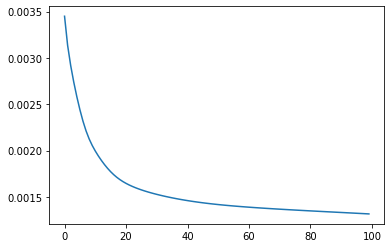

In [34]:
plt.plot(history.history['loss'])

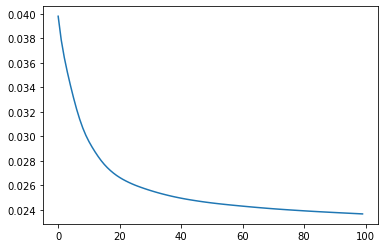

In [35]:
plt.plot(history.history['mean_absolute_error'])

In [36]:
y_err = np.abs(y_pred - y_test)

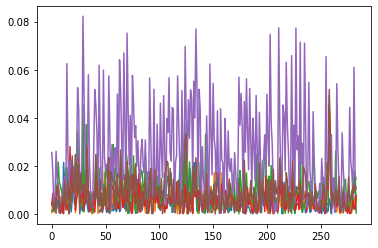

In [37]:
fig, ax = plt.subplots()
ax.plot(y_err)

## Save Model

In [38]:
#model.save("test_model.h5")

In [39]:
#!tensorflowjs_converter --input_format keras "test_model.h5" ./jsmodel